<a href="https://colab.research.google.com/github/jiheddachraoui/occupancy_grid_generator/blob/main/OG_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREPARATION

In [ ]:
import os
import sys
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from collections import Counter
import tensorflow as tf
from sklearn.linear_model import RANSACRegressor
from scipy import stats
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
### Load carla data
datadir = '/content/drive/MyDrive/s_data/'
scenario='scenarios/scenario_test2'
gt='ground truth/scenario_test2_gt'
vehicles=[]
for item in os.listdir(os.path.join(datadir,scenario)):
  vehicles.append(item)
vehicle1=vehicles[0]
vehicle2=vehicles[1]
folder_path1 = os.path.join(datadir,scenario,vehicle1)
folder_path2 = os.path.join(datadir,scenario,vehicle2)
gt_path1 = os.path.join(datadir,gt,vehicle1,'grids')
gt_path2 = os.path.join(datadir,gt,vehicle2,'grids')
print(folder_path1)
print(folder_path2)


/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3
/content/drive/MyDrive/s_data/scenarios/scenario_test2/hero vehicle.lincoln.mkz_2017


In [ ]:
LABEL_COLORS = np.array([
    (255, 255, 255), # None
    (80, 80, 80),    # Building
    (100, 40, 40),   # Fences
    (55, 90, 80),    # Other
    (220, 20, 60),   # Pedestrian
    (153, 153, 153), # Pole
    (157, 234, 50),  # RoadLines
    (128, 64, 128),  # Road
    (244, 35, 232),  # Sidewalk
    (107, 142, 35),  # Vegetation
    (0, 0, 142),     # Vehicle
    (102, 102, 156), # Wall
    (220, 220, 0),   # TrafficSign
    (70, 130, 180),  # Sky
    (81, 0, 81),     # Ground
    (150, 100, 100), # Bridge
    (230, 150, 140), # RailTrack
    (180, 165, 180), # GuardRail
    (250, 170, 30),  # TrafficLight
    (110, 190, 160), # Static
    (170, 120, 50),  # Dynamic
    (45, 60, 150),   # Water
    (145, 170, 100), # Terrain
]) / 255.0 # normalize each channel [0-1] since is what Open3D uses

REDUCED_LABEL_COLORS = np.array([
    (255, 255, 255), # None
    (128, 64, 128),  # Road RoadLines
    (80, 80, 80),    # Building,Wall, static ,Fences
    (250, 170, 30),    # Other ,GuardRail ,RailTrack ,15Bridge
    (110, 190, 160), # Pole ;TrafficLight; Static
    (107, 142, 35),  # Vegetation
    (0, 0, 142),     # Vehicle Dynamic pedestrians
    (244, 35, 232),  # Sidewalk Ground Terrain
    (70, 130, 180),   # Water

]) / 255.0 # normalize each channel [0-1] since is what Open3D uses
label_names = [
    'None', 'Building', 'Fences', 'Other', 'Pedestrian', 'Pole', 'RoadLines',
    'Road', 'Sidewalk', 'Vegetation', 'Vehicle', 'Wall', 'TrafficSign', 'Sky',
    'Ground', 'Bridge', 'RailTrack', 'GuardRail', 'TrafficLight', 'Static',
    'Dynamic', 'Water', 'Terrain'
]

reduced_label_names = [
    'None', 'Road', 'Building', 'Bridge, Rail, Other', 'Static', 'Vegetation', 'Dynamic',
    'Ground', 'Water'
]

## Get Data

In [ ]:
date =185

In [ ]:
def load_matrix(folder_path,timestamp):
  ts = str(timestamp)
  for file_name in os.listdir(folder_path):
          if os.path.splitext(file_name)[0] == ts:

              file_path = os.path.join(folder_path,file_name)
              print(file_path)
              break

  m=np.load(file_path)
  return m

In [ ]:
### Retrieve the provided calibration data
#matrix transforms the points from lidar space to world space.

transformation_matrices_path=os.path.join(folder_path1, "pos_matrices/lidar_2_world")
transformation_matrices_path1=os.path.join(folder_path2, "pos_matrices/lidar_2_world")

location_path=os.path.join(folder_path1, "location")
location_path1=os.path.join(folder_path2, "location")

ogm_path=os.path.join(folder_path1, "occupancy_grid")
ogm_path1=os.path.join(folder_path2, "occupancy_grid")

'''ogm_path=os.path.join(folder_path1, "sem_grid_gt")
ogm_path1=os.path.join(folder_path2, "sem_grid_gt")'''

ogm1=load_matrix(ogm_path,date)
ogm2=load_matrix(ogm_path1,date)

rot_path=os.path.join(folder_path1, "pos_matrices/rotation_pyr")
rot_path1=os.path.join(folder_path2, "pos_matrices/rotation_pyr")

transform1=load_matrix(transformation_matrices_path,date)
transform2=load_matrix(transformation_matrices_path1,date)

#loc1=load_location(location_path,date)
#loc2=load_location(location_path1,date)

loc1=transform1[:3, 3:].flatten().tolist()
loc2=transform2[:3, 3:].flatten().tolist()

rot1=load_matrix(rot_path,date)
rot2=load_matrix(rot_path1,date)

print('vehicle1 pos: ')
print(transform1)
print()
print('vehicle1 location: ')
print(loc1)
print()
print('vehicle2 pos: ')
print(transform2)
print()
print('vehicle2 location: ')
print(loc2)
print('_________________________________________')




/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/occupancy_grid/185.npy
/content/drive/MyDrive/s_data/scenarios/scenario_test2/hero vehicle.lincoln.mkz_2017/occupancy_grid/185.npy
/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/pos_matrices/lidar_2_world/185.npy
/content/drive/MyDrive/s_data/scenarios/scenario_test2/hero vehicle.lincoln.mkz_2017/pos_matrices/lidar_2_world/185.npy
/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/pos_matrices/rotation_pyr/185.npy
/content/drive/MyDrive/s_data/scenarios/scenario_test2/hero vehicle.lincoln.mkz_2017/pos_matrices/rotation_pyr/185.npy
vehicle1 pos: 
[[ 1.15044473e-03  9.99985158e-01 -5.33080287e-03  3.38846313e+02]
 [-9.99999285e-01  1.14911364e-03 -2.52773461e-04  1.17166016e+02]
 [-2.46643991e-04  5.33108972e-03  9.99985754e-01  1.80201864e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

vehicle1 location:

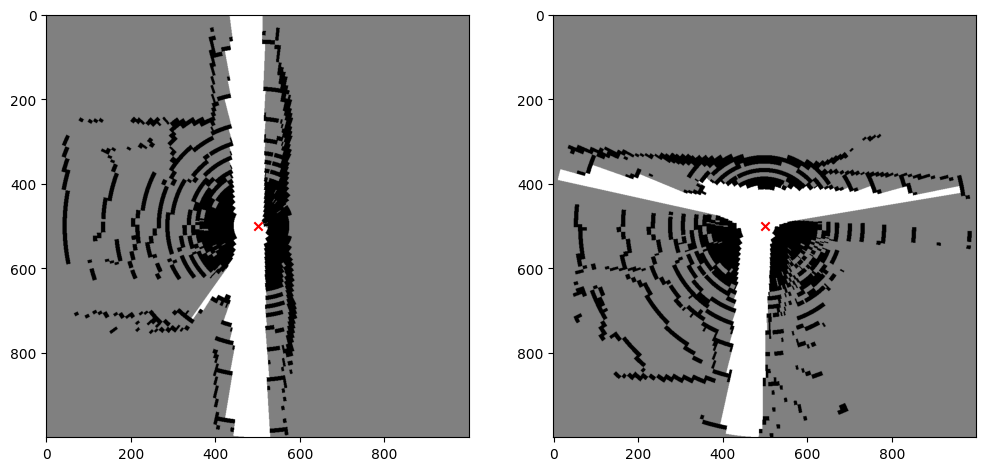

In [ ]:
### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[0].scatter(500,500,c='r',marker='x')
axs[1].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[1].scatter(500,500,c='r',marker='x')
plt.show()

## Shift the map


compute pose from rotation matrix:
<br>
<center><img src="https://image1.slideserve.com/3199301/roll-pitch-yaw-l.jpg" width=400px></center>
</br>

(c=cos(), s=sin())

In [ ]:
# Extract the rotation matrix from the transformation matrix
R1 = np.array(transform1[:3, :3])
R2 = np.array(transform2[:3, :3])
print(R1)
print()
print(R2)

[[ 1.15044473e-03  9.99985158e-01 -5.33080287e-03]
 [-9.99999285e-01  1.14911364e-03 -2.52773461e-04]
 [-2.46643991e-04  5.33108972e-03  9.99985754e-01]]

[[ 9.97667074e-01  6.82652295e-02  4.69486578e-04]
 [-6.82644174e-02  9.97666061e-01 -1.55741163e-03]
 [-5.74707869e-04  1.52172917e-03  9.99998689e-01]]


In [ ]:
'''pitch1 = np.arcsin(R1[1, 2])
yaw1 = -np.arctan2(R1[0, 2], R1[2, 2])
roll1 = np.arctan2(R1[1, 0], R1[1, 1])'''

pitch1 = np.arcsin(R1[2, 0])
yaw1 = -np.arctan2(R1[1, 0], R1[0, 0])
roll1 = -np.arctan2(R1[2, 1], R1[2, 2])

print(pitch1* 180 / np.pi,yaw1* 180 / np.pi,roll1* 180 / np.pi)
print(rot1)

-0.014131659868508884 89.93408435422437 -0.305450398760331
[-1.41316606e-02 -8.99340820e+01 -3.05450410e-01]


In [ ]:
'''pitch2 = np.arcsin(R2[1, 2])
yaw2 = -np.arctan2(R2[0, 2], R2[2, 2])
roll2 = np.arctan2(R2[1, 0], R2[1, 1])'''

pitch2 = np.arcsin(R2[2, 0])
yaw2 = -np.arctan2(R2[1, 0], R2[0, 0])
roll2 = -np.arctan2(R2[2, 1], R2[2, 2])

print(pitch2* 180 / np.pi,yaw2* 180 / np.pi,roll2* 180 / np.pi )
print(rot2)

-0.03292833713117036 3.914307902346493 -0.08718870578679967
[-0.03292834 -3.91430783 -0.08718871]


In [ ]:
'''yaw1=rot1[1]
yaw2=rot2[1]'''

'yaw1=rot1[1]\nyaw2=rot2[1]'

In [ ]:
pose1=np.array([loc1[0],loc1[1],yaw1])
pose2=np.array([loc2[0],loc2[1],yaw2])

In [ ]:
'''pose1=np.array([loc1[0],loc1[1],rot1[1]])
pose2=np.array([loc2[0],loc2[1],rot2[1]])'''

'pose1=np.array([loc1[0],loc1[1],rot1[1]])\npose2=np.array([loc2[0],loc2[1],rot2[1]])'

In [ ]:
RESOLUTION = 0.1
# Calculate the relative position of the two vehicles
rel_pos = pose2[:2] - pose1[:2]
rel_orientation = pose2[2] - pose1[2]

# Define the translation and rotation matrices
#translation_matrix = np.array([[1, 0, -rel_pos[0]], [0, 1, -rel_pos[1]], [0, 0, 1]])
rotation_matrix = np.array([[np.cos(rel_orientation), -np.sin(rel_orientation), 0], [np.sin(rel_orientation), np.cos(rel_orientation), 0], [0, 0, 1]])
print(rotation_matrix)
print(-rel_pos[1]/RESOLUTION,-rel_pos[0]/RESOLUTION)
print(rel_orientation)


[[ 0.06941215  0.99758807  0.        ]
 [-0.99758807  0.06941215  0.        ]
 [ 0.          0.          1.        ]]
-163.24295043945312 97.9754638671875
-1.5013283209147545


In [ ]:
pose1=np.array([loc1[0],loc1[1],yaw1])
pose2=np.array([loc2[0],loc2[1],yaw2])

-1.5696458817475336
[[-9.79754639]
 [16.32429504]]
[ 97.78759703 163.35555777   0.        ] 86.01977645187787


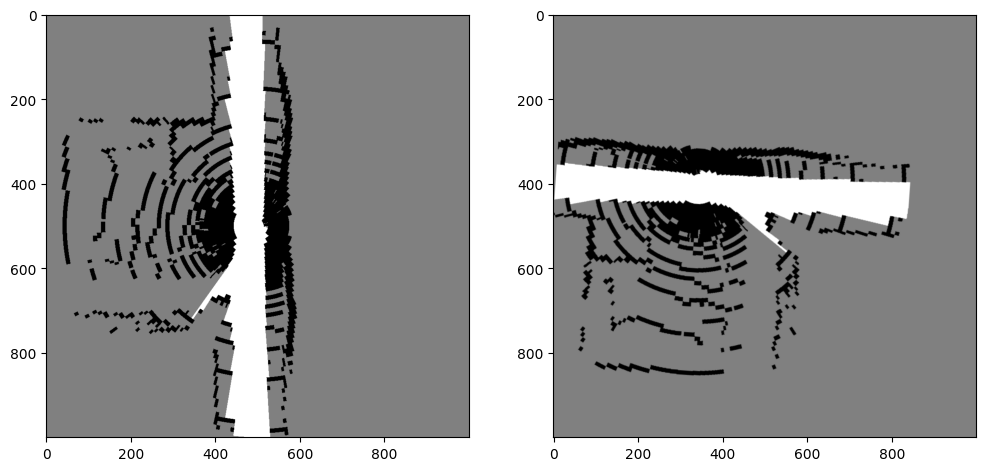

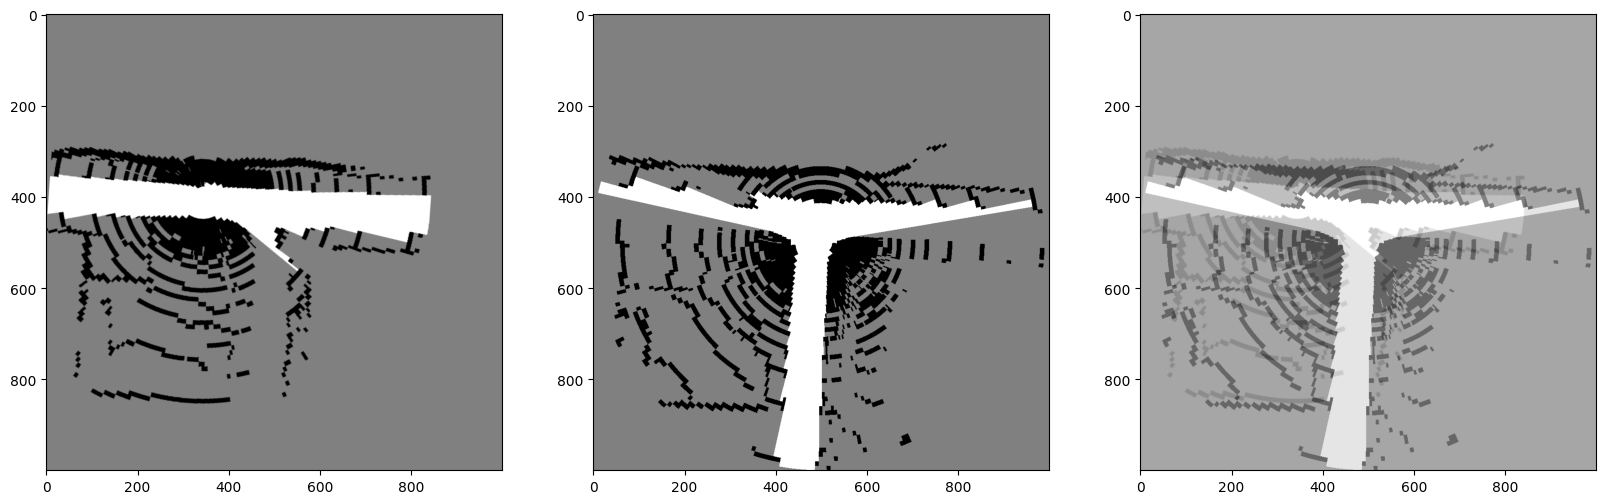

In [ ]:
RESOLUTION = 0.1
# Shift the map according the vehicle's poses
def shift_pose_ogm(ogm, init, fin):
  ogm_o = ogm.copy()
  theta = -init[2]
  #theta = init[2]

  print(theta)
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  print(point_1)
  point_2 = np.dot(rot_m,-point_1)


  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])
  print(delta,-delta_theta* 180 / np.pi)
  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(ogm_o,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),-delta_theta* 180 / np.pi,1)
  #M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)

  return dst

ogm1_transformed = shift_pose_ogm(ogm1,pose1,pose2)

fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray')

plt.show()

fig,axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[2].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray', alpha=0.4)
axs[2].imshow(((1-ogm2)*255).astype(np.uint8), cmap='gray', alpha=0.5)
plt.show()

# MAPPING (DGM)

In OGM, it is hard to tell which one among the detected obstacles are dynamic objects. Many imporvements have been done to make the OGM can store the information of dynamics object, which leads to a new type of grid map: Dynamic Grid Map (DGM). One simple approach that can be used to generate DGM is by using Dempster-Shafer Theory (DST), also known as evidential theory, to estimate the map instead of using probabilistic Bayesian theory.

## load lidar data

In [ ]:
lidar1=folder_path1+'/lidar_nonroad'
lidar2=folder_path2+'/lidar_nonroad'


lidar_nonroad1 = np.load(lidar1+'/{}.npy'.format(date))
lidar_nonroad2 = np.load(lidar2+'/{}.npy'.format(date))


## Parameters

The parameters mostly similar with OGM, but with addition:
- FREE_CONF = Our confidence level [0,1] in the results that are categorized as free.
- OCC_CONF = Our confidence level [0,1] in the results that are categorized as occupied.
- DYNAMIC_THRESHOLD = The minimal value of $m(\emptyset)$ to categorize a cell as occupied by dynamic object.



In [ ]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1

MAX_RANGE = 50
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6
FREE_CONF = 0.7
OCC_CONF = 0.7
DYNAMIC_THRESHOLD = 0.4

## Map Initialization

The OGM is initialized with mass function of all of its cells, $m(\{F\})=0,m(\{O\})=0,m(\{F,O\})=1,m(\emptyset)=0$.

This means that we still don't have any information about the occupancy of the cells.

In [ ]:
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

'''
DGM Channel:
Channel 0 = {F,O}
Channel 1 = O
Channel 2 = F
'''
dgm_time_0 = np.zeros((MAP_SIZE_Y,MAP_SIZE_X,3))
dgm_time_0[:,:,0] = 1

lidar_dgm1 = lidar_nonroad1[:,[0,1]]
lidar_dgm2 = lidar_nonroad2[:,[0,1]]

## Generate Measurement Grid from Filtered LiDAR

The overall process of scan grid generation is the same as in OGM. The only difference is how we fill the cells according to condition 1, 2, and 3 (refer to the image in OGM measurement grid generation code). Cell under condition:

1. (Black cells/likely to be occupied) - are given mass function

\begin{align}m(\{F\})=0, m(\{O\})=OCC\_CONF, m(\{F,O\})=1-OCC\_CONF\end{align}

2. (White cells/likely to be free) - are given mass function

\begin{align}m(\{F\})=FREE\_CONF, m(\{O\})=0, m(\{F,O\})=1-FREE\_CONF\end{align}

3. (Gray cells/unknown) - are given mass function

\begin{align}m(\{F\})=0, m(\{O\})=0, m(\{F,O\})=1\end{align}

The value of $m(\emptyset)$ is 0 and should always be 0, according to DST. We only use $m(\emptyset)$ to detect dynamic cells at an instant time.


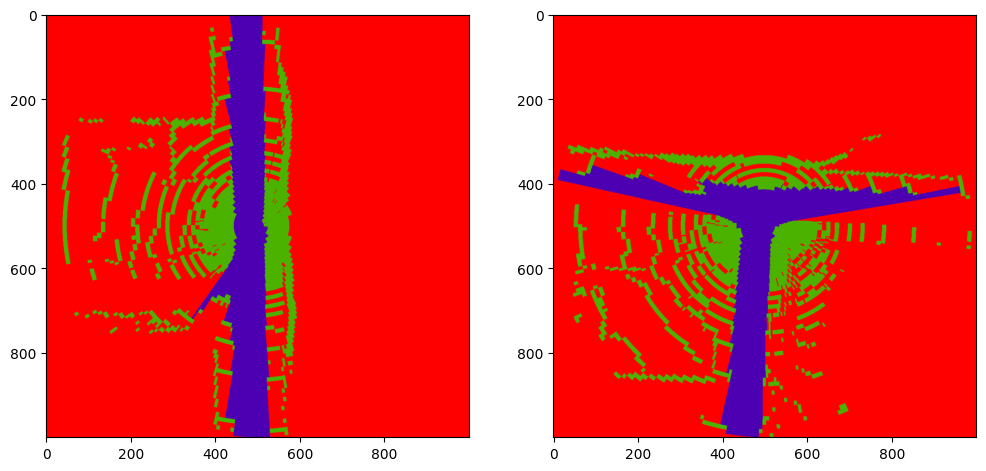

In [ ]:
def generate_measurement_dgm(lidar_in,dgm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  rphi_meas[:,1] = np.sqrt(np.add(np.square(lidar_in[:,0]),np.square(lidar_in[:,1])))/ALPHA
  rphi_meas[:,0] = (np.arctan2(lidar_in[:,1],lidar_in[:,0])+np.pi)/BHETA
  rphi_meas = np.unique(rphi_meas.astype(int),axis=0)
  rphi_meas = rphi_meas[rphi_meas[:,1]<int(MAX_RANGE/ALPHA),:]
  rphi_meas = rphi_meas[rphi_meas[:,0]<int(2*np.pi/BHETA),:]

  ### Initiate and fill the spherical scan grid
  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  scan_grid = np.zeros((sg_ang_bin,sg_rng_bin,3))
  scan_grid[:,:,0] = 1
  scan_grid[tuple(rphi_meas.T)] = (1-OCC_CONF,OCC_CONF,0)
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0:
      scan_grid[ang,:] = (1-FREE_CONF,0,FREE_CONF)
    else:
      min_r = np.min(ang_arr)
      scan_grid[ang,:min_r] = (1-FREE_CONF,0,FREE_CONF)

  ### Convert the spherical scan grid to the cartesian one
  dgm_sz = (dgm_shape[1],dgm_shape[0])
  dgm_cen = (int(dgm_shape[1]/2),int(dgm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS
  dgm_step = cv2.warpPolar(scan_grid,dgm_sz,dgm_cen,radius,cv2.WARP_INVERSE_MAP)
  dgm_step[OOR_MASK] = (1,0,0)
  dgm_step = cv2.rotate(dgm_step, cv2.ROTATE_90_CLOCKWISE)
  return dgm_step

dgm1 = generate_measurement_dgm(lidar_dgm1,dgm_time_0.shape)
dgm2 = generate_measurement_dgm(lidar_dgm2,dgm_time_0.shape)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow((dgm1*255).astype(np.uint8))
axs[1].imshow((dgm2*255).astype(np.uint8))
plt.show()

In [ ]:
print(dgm1[500,500])

[0.3 0.  0.7]


## Try First Update

The update of DGM is done with Dempster's rule of combination. By theory, to combine two mass functions $m_1$ and $m_2$ into a new mass function $m_{1,2}$, the following formula is used

\begin{align}
m_{1,2}(A)=\frac{1}{1-K}\sum_{B\cap C=A\neq\emptyset} m_1(B).m_2(C)
\end{align}

\begin{align}
m(\emptyset) = 0
\end{align}

\begin{align}
K=\sum_{B\cap C=\emptyset} m_1(B).m_2(C)
\end{align}

Note that te sum of all evindeces in a mass function must be equal to 1. If we apply it to the DGM case, the combination rule will be

\begin{align}
m_{1,2}(\{F\})=\frac{1}{1-K}(m_1(\{F\}).m_2(\{F,O\}) + m_1(\{F,O\}).m_2(\{F\}))
\end{align}

\begin{align}
m_{1,2}(\{O\})=\frac{1}{1-K}(m_1(\{O\}).m_2(\{F,O\}) + m_1(\{F,O\}).m_2(\{O\}))
\end{align}

\begin{align}
m_{1,2}(\{F,O\})=\frac{1}{1-K}(m_1(\{F,O\}).m_2(\{F,O\}))
\end{align}

\begin{align}
m_{1,2}(\emptyset) = 0
\end{align}

\begin{align}
K=m_1(\{O\}).m_2(\{F\}) + m_1(\{F\}).m_2(\{O\}))
\end{align}

.The conflicting evidence is actually calculated as $K$. But because the DST only allow $m(\emptyset)$ to be 0, this factor is used as normalization factor for others.

To categorize the cells, we only need to find the maximum mass in its mass function. For example, if the maximum mass is $F$, it will be categorized as free cell. But, cells that have $K>DYNAMIC\_THRESHOLD$ will be classified as dynamic cells.


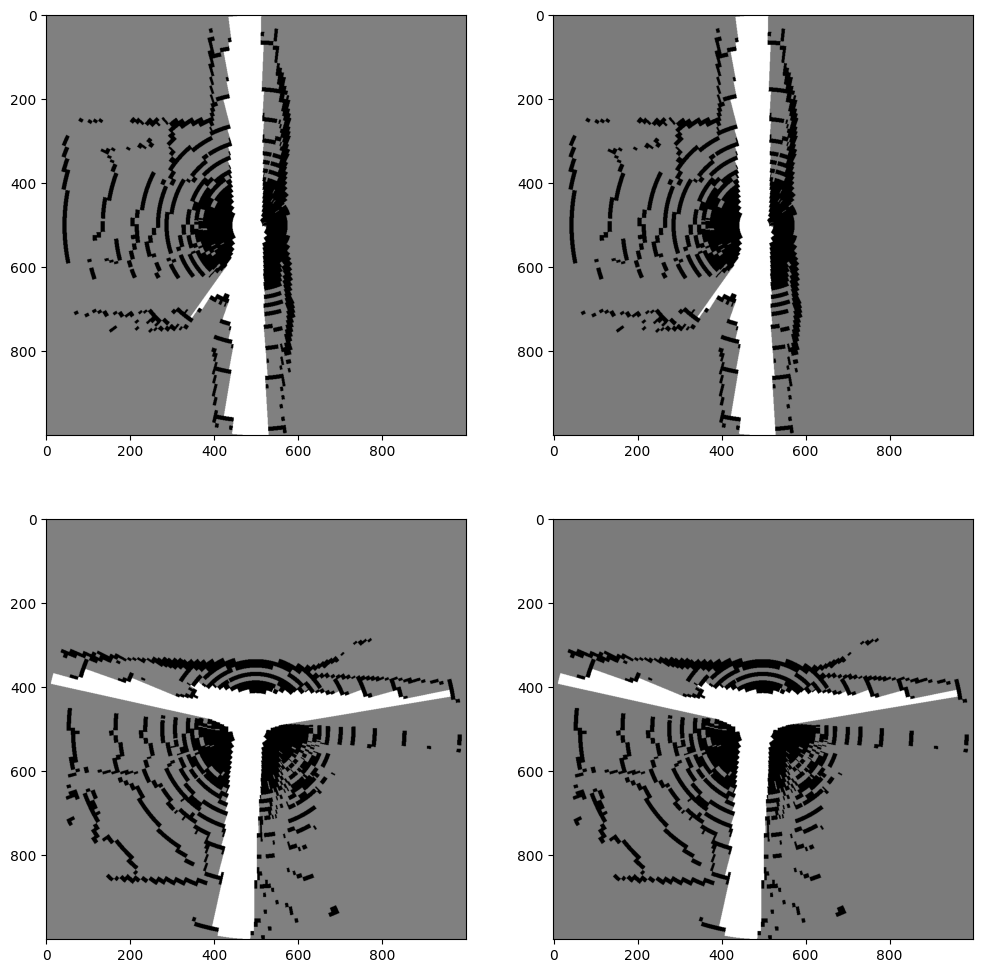

In [ ]:
### Update the DGM with DST rule of combination
def update_dgm(prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))

  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))
  free_mass = np.divide(free_mass,1-conflict_mass)

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))
  occ_mass = np.divide(occ_mass,1-conflict_mass)

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
  unknown_mass = np.divide(unknown_mass,1-conflict_mass)

  updated_dgm = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  return updated_dgm,conflict_mass

### Convert the DGM to a displayable figure
def predict_dgm(dgm,dynamic_mass,dt=DYNAMIC_THRESHOLD):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)
  # The unknown cells: gray
  pred_map[max_mass==0] = (123,123,123)
  # The occupied cells: black
  pred_map[max_mass==1] = (0,0,0)
  # The free cells: white
  pred_map[max_mass==2] = (255,255,255)
  # The dynamic cells: blue
  pred_map[dynamic_mass>=dt] = (0,0,255)
  return pred_map.astype(np.uint8)

dgm_time_1,dynamic_mass_1 = update_dgm(dgm_time_0,dgm1)
dgm_pred_1 = predict_dgm(dgm_time_1,dynamic_mass_1)
dgm_time_2,dynamic_mass_2 = update_dgm(dgm_time_0,dgm2)
dgm_pred_2 = predict_dgm(dgm_time_2,dynamic_mass_2)

fig,axs = plt.subplots(2,2,figsize=(12,12))
axs[0,0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[0,1].imshow(dgm_pred_1)
axs[1,0].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[1,1].imshow(dgm_pred_2)

plt.show()

## Shift the DGM

Shift the OGM with the same way as with OGM

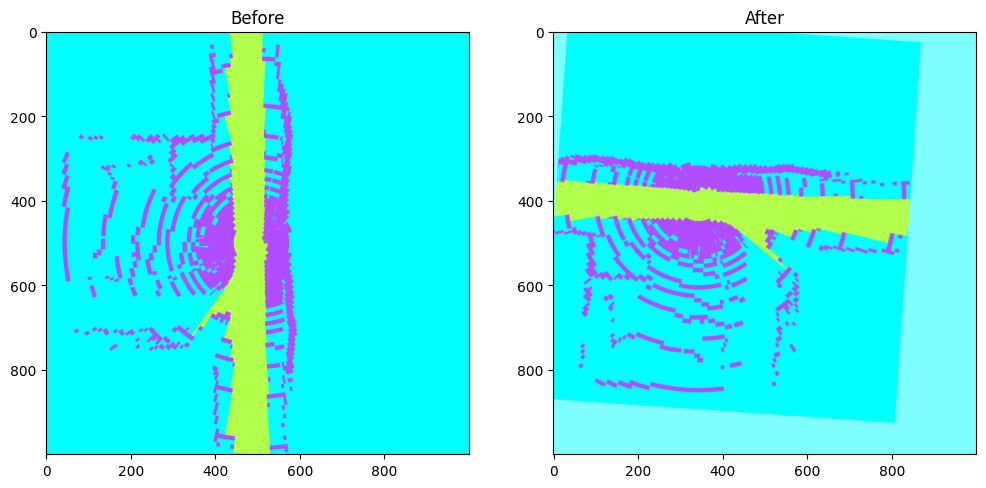

In [ ]:
#RESOLUTION=RESOLUTION -25
# Shift the map according the vehicle's poses
def shift_pose_dgm(dgm, init, fin):
  dgm_o = dgm.copy()
  #theta = init[2] /180 * np.pi
  theta = -init[2]
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])

  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(dgm_o,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),-delta_theta* 180 / np.pi,1)
  #M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  return dst

shift_dgm_time_1 = shift_pose_dgm(dgm_time_1,pose1,pose2)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-dgm_time_1)*255).astype(np.uint8),cmap='gray')
axs[0].set_title('Before')
axs[1].imshow(((1-shift_dgm_time_1)*255).astype(np.uint8),cmap='gray')
axs[1].set_title('After')
plt.show()

## The Second Update

Let's update the map again!

The dynamic cells are colored blue.

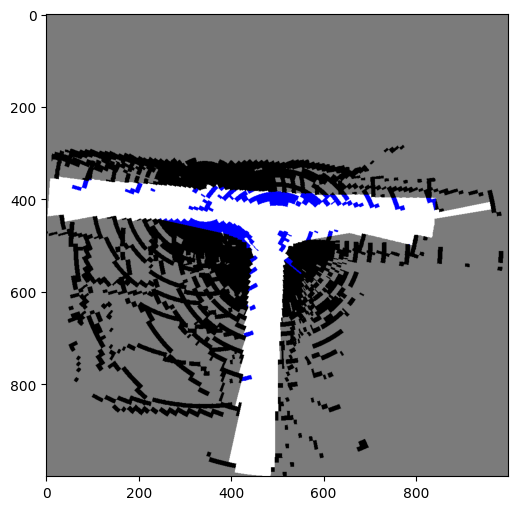

In [ ]:
dgm_fuse,dynamic_mass_fuse = update_dgm(shift_dgm_time_1,dgm_time_2)
dgm_pred_fuse = predict_dgm(dgm_fuse,dynamic_mass_fuse,0.4)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(dgm_pred_fuse)
plt.show()

In [ ]:
print(dgm_pred_fuse[500,500])
print(dgm_fuse[500,500])

[255 255 255]
[0.09 0.   0.91]


# Evaluate

/content/drive/MyDrive/s_data/ground truth/scenario_test2_gt/adversary vehicle.tesla.model3/grids/bird_ogm_gt/185.npy
/content/drive/MyDrive/s_data/ground truth/scenario_test2_gt/hero vehicle.lincoln.mkz_2017/grids/bird_ogm_gt/185.npy


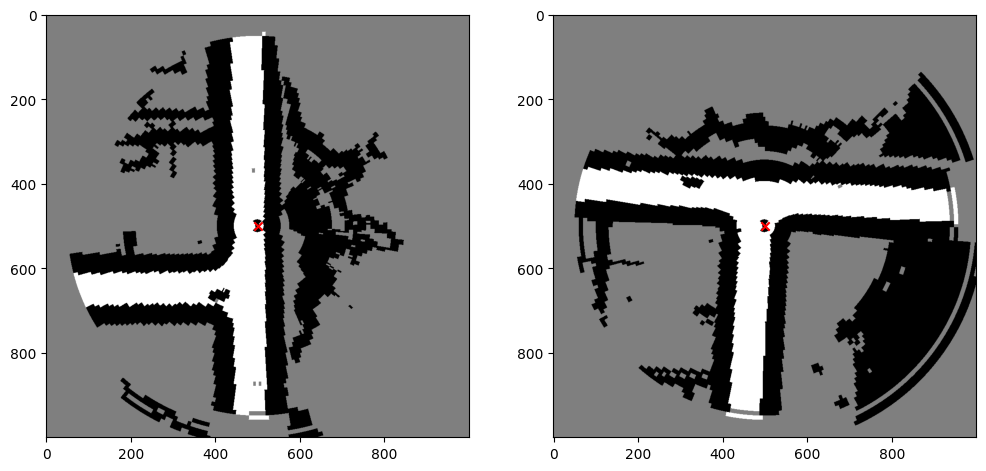

In [ ]:
gt1=load_matrix(os.path.join(gt_path1, "bird_ogm_gt"),date)
gt2=load_matrix(os.path.join(gt_path2, "bird_ogm_gt"),date)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-gt1)*255).astype(np.uint8),cmap='gray')
axs[0].scatter(500,500,c='r',marker='x')
axs[1].imshow(((1-gt2)*255).astype(np.uint8),cmap='gray')
axs[1].scatter(500,500,c='r',marker='x')
plt.show()

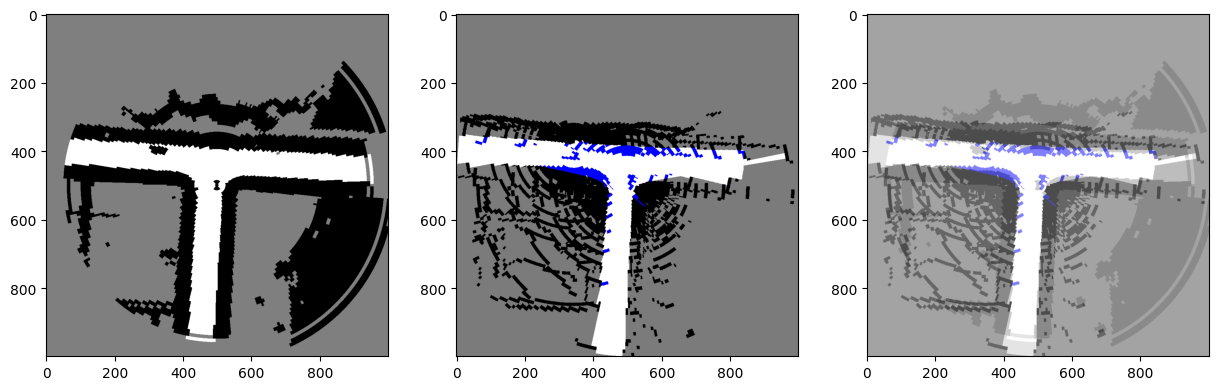

In [ ]:
c=((1-gt2)*255).astype(np.uint8)

fig,axs = plt.subplots(1,3,figsize=(15,12))
axs[0].imshow(c,cmap='gray')
axs[1].imshow(dgm_pred_fuse)

axs[2].imshow(c,cmap='gray', alpha=0.4)
axs[2].imshow(dgm_pred_fuse, alpha=0.5)
plt.show()

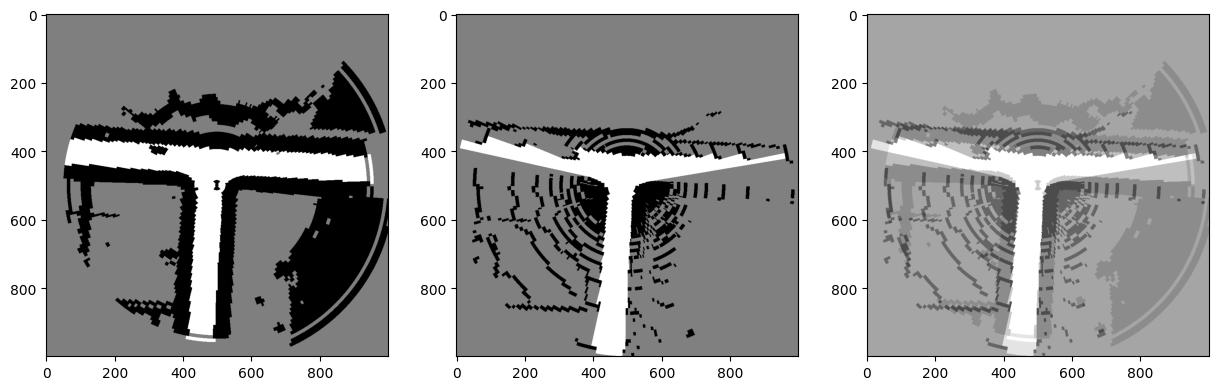

In [ ]:
c=((1-gt2)*255).astype(np.uint8)

fig,axs = plt.subplots(1,3,figsize=(15,12))
axs[0].imshow(c,cmap='gray')
axs[1].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')

axs[2].imshow(c,cmap='gray', alpha=0.4)
axs[2].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray', alpha=0.5)
plt.show()